In [51]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR 
from sklearn.neighbors import KNeighborsRegressor
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer


Criando o dicionário sobre os dados disnponiveis 
(
    CRIM: Taxa de criminalidade per capita por cidade
    ZN: proportção de hectares de negócios não-varejo por cidade
    INDUS: Proporção de hectares de negócios não-varejo por cidade
    CHAS: variável ficticia do rio charles (1 se o tract se delimita caso não 0)
    NOX: Concentração de óxido nitrico
    RM: Número médio de quartos por habitação
    AGE: Proporção de unidades coupadas pelo proprietário construidas antes de 1940
    DIS: Indice de acessibilidade a rodovias radiais
    TAX: Taxa de imposto de propriedade de valor total por US $ 10.000
    PTRATIO: relação aluno-altafegado por cidade
    B: O resultado da equação B-1000(Bk - 0,63) onde Bk é a proporção de negros por cidade
    LSTAT: % inferior ao status da população

MEDV: Valor médio da
)

In [5]:
house = pd.read_csv('boston.csv', sep =',')
print('Informações gerais dos dados')
print(house.info())
print('Descrição Geral dos dados')
print(house.describe())

Informações gerais dos dados
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
Descrição Geral dos dados
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.61

In [10]:
house.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [37]:
import matplotlib.pyplot as plt 
# plotando alguns gráficos para melhorar o entendimento dos dados
# Histogramas



fig = px.histogram(house,x='AGE', y='MEDV', color= 'RAD')
fig


In [44]:
fig1 = px.scatter(house, x = 'CRIM', y='AGE')
fig1

fig_tax = px.scatter(house, x ='MEDV', y= 'TAX', title ='Impostos VS Preço')
fig_tax

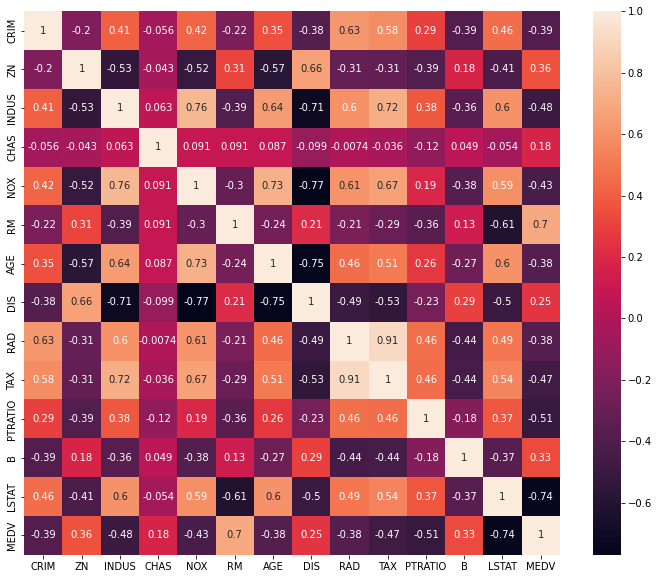

In [48]:
import seaborn as sns 
plt.figure(figsize=(12,10))
sns.heatmap(house.corr(), annot = True)
plt.show()

Para esse modelo eu vou adotar três abordagens diferentes.
Primeira: Vou trainar os modelos sem escalonas os dados e sem fazer o gridSearch
Segundo: Vou fazer o grid search com os dados escalonados e não escalonados
Terceiro: Vou retirar os outliear e normalizar os dados e comparar qual modelo performou melhor

## Primeira etapa 

In [55]:
# Instanciando os modelos
linear = LinearRegression()
svm = LinearSVR()
knn = KNeighborsRegressor()

# Separando os dados em treino e teste

x = house.drop('MEDV', axis=1)
y = house['MEDV']

x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.12, random_state=42)



In [56]:
y_train

55     35.4
229    31.5
18     20.2
351    24.1
209    20.0
       ... 
106    19.5
270    21.1
348    24.5
435    13.4
102    18.6
Name: MEDV, Length: 445, dtype: float64